# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import re

from collections import Counter

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn import preprocessing

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

pd.set_option('display.max_colwidth', -1)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [6]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [7]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [9]:
data['URL_TA']

0        /Restaurant_Review-g187147-d10746918-Reviews-Le_Perchoir-Paris_Ile_de_France.html                                         
1        /Restaurant_Review-g189934-d6674944-Reviews-Ravintola_Kolmon3n-Helsinki_Uusimaa.html                                      
2        /Restaurant_Review-g186525-d13129638-Reviews-Black_Ivy-Edinburgh_Scotland.html                                            
3        /Restaurant_Review-g186338-d680417-Reviews-Quirinale-London_England.html                                                  
4        /Restaurant_Review-g274924-d1112354-Reviews-Massimo_Ristorante-Bratislava_Bratislava_Region.html                          
                                                       ...                                                                         
49995    /Restaurant_Review-g187849-d2104414-Reviews-Rosso_Brera-Milan_Lombardy.html                                               
49996    /Restaurant_Review-g187147-d1800036-Reviews-La_Favorite-Paris_Ile_d

In [10]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
9925,id_9925,Stockholm,"['Bar', 'Pub']",814.0,$$ - $$$,32.0,"[['Perfect view, hotel roof garden, 8 floor...', 'Decent hotel bar'], ['06/09/2017', '02/10/2017']]",/Restaurant_Review-g189852-d10756306-Reviews-The_Capital-Stockholm.html,d10756306,0,0.0
13868,id_1309,Munich,"['Cafe', 'European', 'Turkish', 'Vegetarian Friendly', 'Vegan Options']",1321.0,$$ - $$$,90.0,"[['Nice turkish style cuisine', 'Perfect for lunch'], ['01/06/2018', '06/20/2017']]",/Restaurant_Review-g187309-d966489-Reviews-Cafe_Altschwabing-Munich_Upper_Bavaria_Bavaria.html,d966489,1,4.0
17439,id_611,Oporto,"['European', 'Portuguese']",612.0,$$ - $$$,41.0,"[['Good food and a nice place for a business...', 'Consider a visit'], ['09/07/2015', '12/24/2014']]",/Restaurant_Review-g189180-d4288374-Reviews-Restaurante_Fundacao_Dr_Antonio_Cupertino_de_Miranda-Porto_Porto_District_Norther.html,d4288374,1,4.0
45030,id_316,Milan,"['Italian', 'Seafood', 'Mediterranean', 'European']",317.0,$$$$,547.0,"[['charming and elegant place adaptable for b...', 'Excellent fish and with wine'], ['08/24/2017', '05/12/2017']]",/Restaurant_Review-g187849-d1069434-Reviews-Bianca-Milan_Lombardy.html,d1069434,1,4.5
40773,id_6642,Madrid,NaN,6645.0,NaN,7.0,"[[], []]",/Restaurant_Review-g187514-d6367297-Reviews-Bar_Restaurante_Silos-Madrid.html,d6367297,1,3.5


Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# 2. Обработка признаков
## 2.1 Обработка ресторан ID

In [11]:
def edit_rest_id(df_input):    
    # full edit restaurant_id 
    
    df = df_input.copy()
    
    # создания признака один ли ресторан или это сеть
    df['Restaurant_id'] = df['Restaurant_id'].apply(lambda x: int(x[3:]))
    chain_restaurant = df.groupby('Restaurant_id')['City'].count().rename('one_or_more')
    df = pd.merge(df, chain_restaurant, on='Restaurant_id')
    
    return df

In [12]:
edit_rest_id(data).sample(2)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,one_or_more
21283,2131,Vienna,"['International', 'Vegetarian Friendly']",2133.0,NaN,9.0,"[['Cheap and chirpy', 'Cheap but delicious lunch'], ['05/27/2017', '09/20/2016']]",/Restaurant_Review-g190454-d4935586-Reviews-Tongues_Cafe-Vienna.html,d4935586,1,4.5,8
35799,5408,Budapest,"['Italian', 'Pizza', 'Mediterranean', 'European', 'Vegetarian Friendly', 'Vegan Options', 'Gluten Free Options']",50.0,$,349.0,"[['Chic place', 'Fabulous!'], ['01/05/2018', '01/03/2018']]",/Restaurant_Review-g274887-d10287366-Reviews-Al_Dente-Budapest_Central_Hungary.html,d10287366,0,0.0,2


## 2.2 Обработка City

In [13]:
data['City'].unique()

array(['Paris', 'Helsinki', 'Edinburgh', 'London', 'Bratislava', 'Lisbon',
       'Budapest', 'Stockholm', 'Rome', 'Milan', 'Munich', 'Hamburg',
       'Prague', 'Vienna', 'Dublin', 'Barcelona', 'Brussels', 'Madrid',
       'Oslo', 'Amsterdam', 'Berlin', 'Lyon', 'Athens', 'Warsaw',
       'Oporto', 'Krakow', 'Copenhagen', 'Luxembourg', 'Zurich', 'Geneva',
       'Ljubljana'], dtype=object)

Дополнительным признаком можно добавить население. Городов не очень много, поэтому буду просто гуглить. Мне понравился сайт https://datacommons.org/
Буду считать что население не сильно изменилось за пару лет, поэтому не буду обращать внимание на год, за который представлены данные населения

In [14]:
# население для каждого города из датасета
population = {
    'Paris': 2160928,
    'Helsinki': 631695,
    'Edinburgh': 482005,
    'London': 8982256,
    'Bratislava': 424428,
    'Lisbon': 504718,
    'Budapest': 1756056,
    'Stockholm': 789024,
    'Rome': 2873494,
    'Milan': 1351562,
    'Munich': 1471508,
    'Hamburg': 1841179,
    'Prague': 1308632,
    'Vienna': 1897491,
    'Dublin': 544107,
    'Barcelona': 1620343,
    'Brussels': 174383,
    'Madrid': 3223334,
    'Oslo': 634293,
    'Amsterdam': 869709,
    'Berlin': 3644826,
    'Lyon': 513275,
    'Athens': 664046,
    'Warsaw': 1764615,
    'Oporto': 214349,
    'Krakow': 766683,
    'Copenhagen': 602481,
    'Luxembourg': 114303,
    'Zurich': 402762,
    'Geneva': 198979,
    'Ljubljana': 279631              
}

In [15]:
# принадлежность города к стране
country = {
    'Paris': 'France',
    'Hamburg': 'Germany',
    'Rome': 'Italy',
    'London': 'UK',
    'Milan': 'Italy',
    'Madrid': 'Spain',
    'Oslo': 'Norway',
    'Stockholm': 'Sweden',
    'Krakow': 'Poland',
    'Lyon': 'Paris',
    'Lisbon': 'Portugal',
    'Edinburgh': 'UK',
    'Vienna': 'Austria',
    'Warsaw': 'Poland',
    'Amsterdam': 'Netherlands',
    'Budapest': 'Hungary',
    'Helsinki': 'Finland',
    'Zurich': 'Switzerland',
    'Luxembourg': 'Luxembourg',
    'Berlin': 'Germany',
    'Prague': 'Czechia',
    'Munich': 'Germany',
    'Bratislava': 'Slovakia',
    'Brussels': 'Belgium',
    'Ljubljana': 'Slovenia',
    'Copenhagen': 'Denmark',
    'Oporto': 'Portugal',
    'Barcelona': 'Spain',
    'Geneva': 'Switzerland',
    'Athens': 'Greece',
    'Dublin': 'Ireland'
}

In [16]:
# вышло так, что городов не столиц оказалось меньше, поэтому что меньше писать составлю из них список
not_Capital = ['Barcelona', 'Milan', 'Hamburg', 'Munich','Lyon', 'Zurich', 'Oporto', 'Geneva', 'Krakow']

In [17]:
def create_dummy(df_input, series, n=10):
    # one hot encoding for n popular elements
    df = df_input.copy()    
    # list of n top elements
    top_elements = df[series].value_counts().index[:n]
    
    df[series] = df[series].apply(lambda x: x if x in top_elements else 'other')
    
    # create dummy for elements in top_elements
    dummy = pd.get_dummies(df[series])
    df = pd.concat([df, dummy], axis=1)
    
    return df

In [18]:
def edit_city(df_input):
    # full edit city and about city
    
    df = df_input.copy()
    scaler = StandardScaler()
    
    # население каждого города
    df['population'] = df['City'].map(population)

    # Определение страны для каждого города из датасета
    df['country'] = df['City'].map(country)

    # сколько ресторанов в каждом городе
    restaurant_in_city = df.groupby('City')['Reviews'].count().rename('restaurant_in_city')
    df = pd.merge(df, restaurant_in_city, on='City')

    # количество ресторанов на каждого человека
    df['restaurant_per_person'] = df['restaurant_in_city'] / df['population']
    df['restaurant_per_person'] = scaler.fit_transform(df[['restaurant_per_person']])

    # столица или не столица
    df['capital'] = df['City'].apply(lambda x: 0 if x in not_Capital else 1 )

    return df    

In [19]:
edit_city(data).sample(2)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,population,country,restaurant_in_city,restaurant_per_person,capital
31019,id_661,Barcelona,"['Seafood', 'Mediterranean', 'European', 'Spanish', 'Soups', 'Gluten Free Options', 'Vegetarian Friendly']",662.0,$$ - $$$,1332.0,"[['Too expensive & not much', 'Second but reasonable choice for late lunc...'], ['12/25/2017', '11/23/2017']]",/Restaurant_Review-g187497-d1137212-Reviews-La_Gavina-Barcelona_Catalonia.html,d1137212,1,3.5,1620343,Spain,3395,0.337554,0
3138,id_5650,Paris,"['Mediterranean', 'Tunisian']",5651.0,$$ - $$$,65.0,"[['Delicious!', 'Absolutely amazing, delicious, perfect.'], ['01/11/2017', '07/21/2016']]",/Restaurant_Review-g187147-d3924288-Reviews-La_Corniche-Paris_Ile_de_France.html,d3924288,1,4.0,2160928,France,6108,0.918526,1


Возможно надо подумать над признаком, туристический ли это город или нет. Или сколько денег приносит в бюджет города, но пока что не знаю как это реализовать.

Были создананы следующие признаки:
- население каждого города
- принадлежность города к стране
- количество ресторанов для каждого города
- из этого можно получить количество ресторанов на каждого человека
- является ли город столицей 
- dummy переменные (видел в других нотбуках label endocting, но не знаю зачем его применять к этому признаку)

## 2.3 Кухни

In [20]:
def only_top_cuisins(string):
#     возвращает только популярные кухни
    output = []

    string_to_list = re.findall(r"'(\b.*?\b)'", string)
    # проверка для каждой входит ли в топ
    for cuisin in string_to_list:
        if cuisin in top_cuisins:
            output.append(cuisin)
    if not output:
        return ['Other']
    return output

In [21]:
def edit_cuisine(input_df, n=10):
    # edit all about cuisine style
    
    df = input_df.copy()
    global top_cuisins
    
    # создаю столбец, с отметками о том, где были пропуски
    df['Cuisine_style_ISNA'] = df['Cuisine Style'].isna().astype(int)

    # заполнение пропусков
    df['Cuisine Style'] = df['Cuisine Style'].fillna("['Other']")
    
    # топ кухонь по популярности
    # перебор список все списков видов кухни
    all_cuisins = df['Cuisine Style'].str.findall(r"'(\b.*?\b)'")
    cuisins = []
    for list_cuisins in all_cuisins:
        for style in list_cuisins:
            cuisins.append(style)
    # создание списка n популярных кухонь
    set_cuisins = set(cuisins)        
    cuisins = dict(Counter(cuisins))
    cuisins = {keys: values for keys, values in sorted(cuisins.items(), reverse=True, key=lambda x: x[1])}
    top_cuisins = list(cuisins.keys())[:n]
    
    # возвращаю только топ n кухонь, остальные other
    df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: only_top_cuisins(x))

    # разнообразие кухонь
    df['len_cuisine'] = df['Cuisine Style'].apply(len) 
    
    # созднаие dummy переменных для видов кухни
    for cuisin in top_cuisins:
        df[cuisin] = df['Cuisine Style'].apply(lambda x: 1 if cuisin in x else 0)   
    
    return df

In [22]:
edit_cuisine(data, n=5).sample(2)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Cuisine_style_ISNA,len_cuisine,Vegetarian Friendly,European,Other,Mediterranean,Italian
11189,id_9684,Paris,[Other],9686.0,NaN,17.0,"[[], []]",/Restaurant_Review-g187147-d4006807-Reviews-Les_Jardins_d_Epicure-Paris_Ile_de_France.html,d4006807,1,4.0,0,1,0,0,1,0,0
27851,id_1282,Madrid,[Vegetarian Friendly],1284.0,$$ - $$$,72.0,"[['Pleasantly surprised', 'Nice surprise'], ['05/14/2017', '12/03/2016']]",/Restaurant_Review-g187514-d10467435-Reviews-Restaurante_Casa_De_Fieras-Madrid.html,d10467435,1,4.0,0,1,1,0,0,0,0


В признаке достаточно много пропусков
- создал столбец с пометками о пропусках
- пропуски заменил значением other
- создал признак разнообразия кухонь
- создал функцию для создания n популярных dummy переменных

## 2.4 Price Range

In [23]:
# хочу посмотреть самый популярный диапазон цен для каждого города
cities = data['City'].unique()
# отображение самых популярных диапазонов цен для каждого города
for city in cities:
    print(data[data['City']==city]['Price Range'].value_counts().index[0], city)

$$ - $$$ Paris
$$ - $$$ Helsinki
$$ - $$$ Edinburgh
$$ - $$$ London
$$ - $$$ Bratislava
$$ - $$$ Lisbon
$$ - $$$ Budapest
$$ - $$$ Stockholm
$$ - $$$ Rome
$$ - $$$ Milan
$$ - $$$ Munich
$$ - $$$ Hamburg
$$ - $$$ Prague
$$ - $$$ Vienna
$$ - $$$ Dublin
$$ - $$$ Barcelona
$$ - $$$ Brussels
$$ - $$$ Madrid
$$ - $$$ Oslo
$$ - $$$ Amsterdam
$$ - $$$ Berlin
$$ - $$$ Lyon
$$ - $$$ Athens
$$ - $$$ Warsaw
$$ - $$$ Oporto
$$ - $$$ Krakow
$$ - $$$ Copenhagen
$$ - $$$ Luxembourg
$$ - $$$ Zurich
$$ - $$$ Geneva
$$ - $$$ Ljubljana


In [24]:
def edit_price_range(input_df):
    # edit all about price range
    
    df = input_df.copy()
    
    # перед обработкой признака, создаю колонку с отображениями пропуска
    df['Price_Range_isNAN'] = df['Price Range'].isnull().astype(int)

    # выглядит так, что пропуски можно заполнить через fillna самым популярным значением
    df['Price Range'] = df['Price Range'].fillna('$$ - $$$')

    # замена значений типа объект на циферки 
    replace_price_range = {'$': 0, '$$ - $$$': 1, '$$$$':2}
    df['Price Range'] = df['Price Range'].map(replace_price_range)
    
    return df

In [25]:
edit_price_range(data).sample(2)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Price_Range_isNAN
44973,id_6397,Barcelona,NaN,6398.0,1,8.0,"[[], []]",/Restaurant_Review-g187497-d11543677-Reviews-Pans_Company-Barcelona_Catalonia.html,d11543677,1,3.5,1
36787,id_12024,London,"['Chinese', 'Vietnamese']",12034.0,1,7.0,"[['Always fresh food', 'Good food. Great prices. Service so so.'], ['11/21/2017', '05/25/2017']]",/Restaurant_Review-g186338-d7973169-Reviews-New_Tastes-London_England.html,d7973169,1,4.0,1


Никаких новых знаний получить не удалось. В колонке было очень много пропусков. Отменил в датасете этот факт. Заполнил пропуски самым популярным значением. Произвел Label Encoding

## 2. 5 number of reviews

In [26]:
def edit_number_of_reviews(input_df):
    # all about number_of_reviews
    
    df = input_df.copy()
    scaler = StandardScaler()
    
    # отмечу строки с пропусками, для них создам специальный столбец
    df['Number_of_Reviews_isNAN'] = df['Number of Reviews'].isnull().astype(int)

    # заполнение средними по каждому городу, но надо до каонца разобраться с синтаксисом конструкции трансформ
    df['Number of Reviews'] = df.groupby("City")['Number of Reviews'].transform(lambda x: x.fillna(x.mean()))
    
    
    
    
        # средний ранкинг для каждого города
    mean_per_city = df.groupby('City')['Number of Reviews'].mean()
    df['mean_Number_of_Reviews_per_city'] = df['City'].apply(lambda x: mean_per_city[x])

    #  масмимальный ранкинг для каждого города
    max_per_city = df.groupby('City')['Number of Reviews'].max()
    df['max_Number_of_Reviews_per_city'] = df['City'].apply(lambda x: max_per_city[x])

    # стандартизация
    df['stand_Number_of_Reviews'] = (df['Ranking'] - df['mean_Number_of_Reviews_per_city']) / df['max_Number_of_Reviews_per_city']
    
    
    
    
    

    # количество отзывов на каждого человека в городе
    try:
        df['reviews_per_each_person'] = df['Number of Reviews'] / df['population']
    except:
        pass

    # среднее количество отзывов по городам
    reviews_per_city = df.groupby(by='City')['Number of Reviews'].mean()
    df['reviews_per_city'] = df['City'].apply(lambda x: reviews_per_city[x])
    
    try:
        df['reviews_per_each_person'] = scaler.fit_transform(df[['reviews_per_each_person']])
    except:
        pass
    
    return df

In [27]:
edit_city(edit_number_of_reviews(data)).sample(2)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,Number_of_Reviews_isNAN,mean_Number_of_Reviews_per_city,max_Number_of_Reviews_per_city,stand_Number_of_Reviews,reviews_per_city,population,country,restaurant_in_city,restaurant_per_person,capital
27383,id_3878,Prague,['Pizza'],3887.0,$,10.0,"[['Great soups, average panini, bad pizza', 'Good for quick-stop lunch'], ['06/29/2017', '02/24/2016']]",/Restaurant_Review-g274707-d4884751-Reviews-PaniKafe-Prague_Bohemia.html,d4884751,1,...,0,124.377722,4521.0,0.832254,124.377722,1308632,Czechia,1816,-0.224511,1
4203,id_11802,Paris,NaN,11804.0,NaN,63.0,"[['Unacceptable! Unprofessional! Leaves a lot...', 'Great ambiance'], ['12/28/2017', '08/21/2016']]",/Restaurant_Review-g187147-d10042180-Reviews-La_Demesure-Paris_Ile_de_France.html,d10042180,1,...,0,117.040915,7622.0,1.533319,117.040915,2160928,France,6108,0.918526,1


Данные достаточно чистые, но там где были пропуски все равно был создан столбец с пометкой об этом. 
- пропуски заполнены средними значениями для каждого города, есть еще вариант заполнить пропуски нулями, но вывести новый столбец для средних значения для каждого города
- создан столбец с количеством отзывов для каждого человека

## 2.6 Ranking

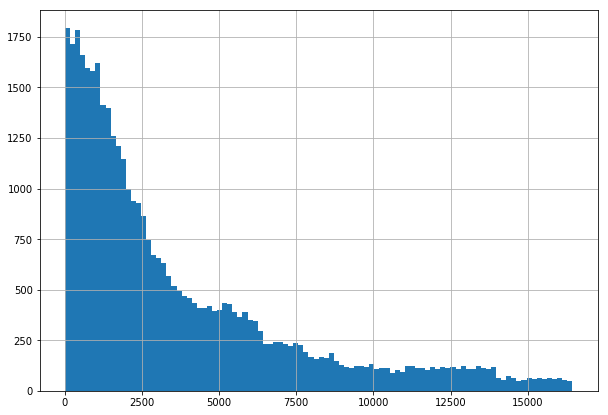

In [28]:
# распределение параметра ранкинг. Много значений, которые даже не дотягивают до 2500 места в своем городе
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

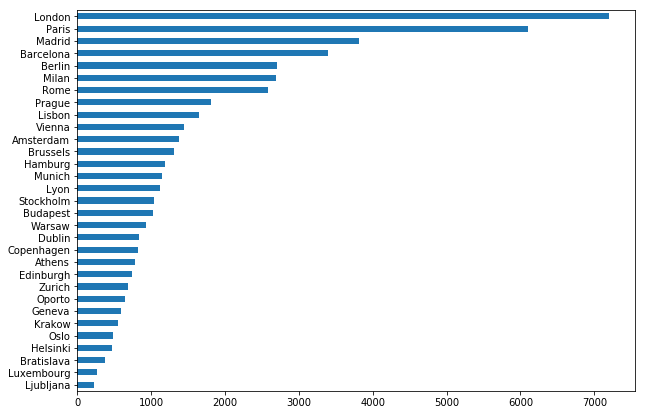

In [29]:
# самые ресторанные города, если можно так сказать
data['City'].value_counts(ascending=True).plot(kind='barh')

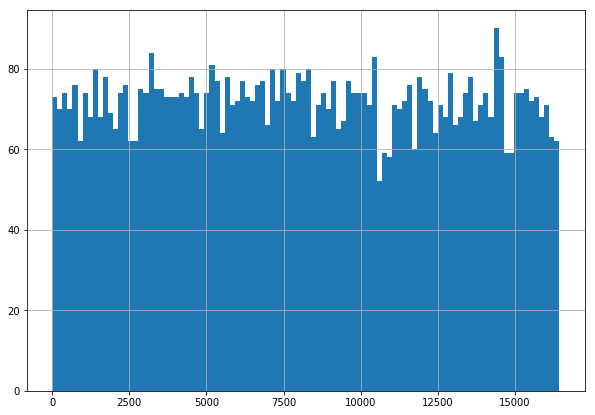

In [30]:
data['Ranking'][data['City'] == 'London'].hist(bins=100)
# не знаю почему это распределение называют нормальным. Для Лондона следующее распределение. Посмотрим на распределение других городов

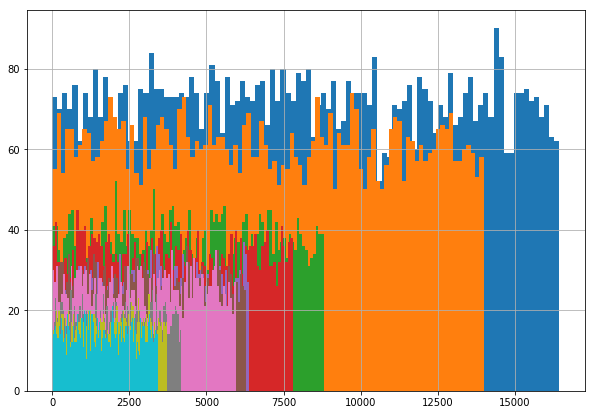

In [31]:
for x in (data['City'].value_counts())[0:10].index:
    data['Ranking'][data['City'] == x].hist(bins=100)
plt.show()

# Здесь видно что форма распределения повторяется, но видно смещение, это связано с размерами города

In [32]:
def edit_ranking(df_input):
    # all about edit
    df = df_input.copy()    
    
    # приведем значения к виду от -1 до 1

    # средний ранкинг для каждого города
    mean_per_city = df.groupby('City')['Ranking'].mean()
    df['mean_ranking_per_city'] = df['City'].apply(lambda x: mean_per_city[x])

    #  масмимальный ранкинг для каждого города
    max_per_city = df.groupby('City')['Ranking'].max()
    df['max_ranking_per_city'] = df['City'].apply(lambda x: max_per_city[x])

    # стандартизация
    df['stand_ranking'] = (df['Ranking'] - df['mean_ranking_per_city']) / df['max_ranking_per_city']
    
    return df

In [33]:
edit_ranking(data).sample(2)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,mean_ranking_per_city,max_ranking_per_city,stand_ranking
49121,id_1592,Lisbon,"['Chinese', 'Asian']",1593.0,$$ - $$$,177.0,"[['One of the best Chinese food...poor settin...', 'Cold service, average food and depressing...'], ['02/17/2018', '09/15/2017']]",/Restaurant_Review-g189158-d3208596-Reviews-Grande_Palacio_Restaurante_Hong_Kong-Lisbon_Lisbon_District_Central_Portugal.html,d3208596,1,3.5,1867.330298,3717.0,-0.073804
45945,id_3913,Barcelona,"['Mediterranean', 'Spanish', 'Diner', 'Steakhouse']",3914.0,$$ - $$$,9.0,"[['Hardly you find this kind of a place in a...', 'Best lunch in Barcelona!'], ['01/03/2017', '01/03/2017']]",/Restaurant_Review-g187497-d10088945-Reviews-Restaurante_Nou_Sanllehy-Barcelona_Catalonia.html,d10088945,1,4.5,3879.422680,7796.0,0.004435


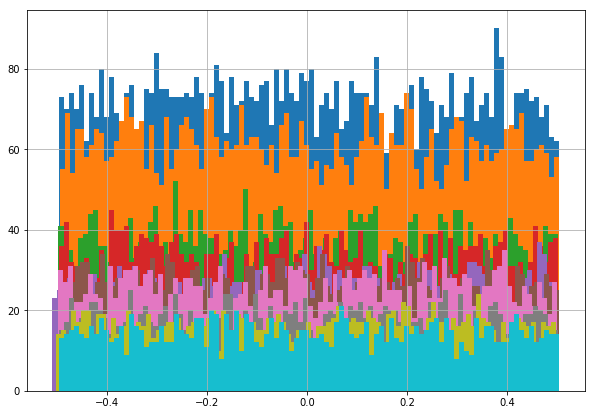

In [34]:
# посмотрим обновленое распределение для тех же городов
test_data = edit_ranking(data)
for x in (test_data['City'].value_counts())[0:10].index:
    test_data['stand_ranking'][test_data['City'] == x].hist(bins=100)
plt.show()

Признак без пропусков. Распределение одинаковое для каждого города. Можно заметить что дейсвительно смещеные было вызвано только размером города

## 2.7 обработка признака Reviews

In [35]:
def days_between_dates(dates):

#     это функция высчитывает количество дней между отзывами
        
    if len(dates) == 0:
        return 1800
    if len(dates) == 1:
        return 3600
    dt_list = []
    for date in dates:
        dt = pd.to_datetime(date)
        dt_list.append(dt)
    return int((max(dt_list) - min(dt_list)).days)

In [36]:
def edit_reviews(df_input):
    # all about edit reviews
    
    df = df_input.copy()
    

    # пропуски найденные с помощью isna() можно заполнить пустыми списками
    df['Reviews'] = df['Reviews'].fillna('[[], []]')

    # создам признак отображающий есть ли пропуск в данном признаке
    df['reviews_is_NAN'] = (df['Reviews'] == '[[], []]').astype(int)

    # признак состоит из двух последних отзывов и даты, в которой этот отзыв оставлен 
    # для начала можно попробовать извлечь значения дат и попробовать извлечь новые знания из этого
    df['date_of_reviews'] = df['Reviews'].str.findall('\d+/\d+/\d+')

    # сразу можно проверить, действительно ли содержится два отзыва
    df['len_date_of_reviews'] = df['date_of_reviews'].apply(len)
        
    # видно что некоторые пользователи записывали дату своего посещения
    # этот можно можно немного отредактировать
    df['date_of_reviews'] = df['date_of_reviews'].apply(lambda x: x[1:] if len(x) > 2 else x)

    # соответственно надо испрвить колонку len_date_of_reviews, т.к. значений = 3 больше нет
    df['len_date_of_reviews'] = df['date_of_reviews'].apply(len)
    
    # создание нового признака. Количество дней между последними отзывами
    df['days_between'] = df['date_of_reviews'].apply(days_between_dates)

    
    return df

In [37]:
edit_reviews(data).head(2)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,reviews_is_NAN,date_of_reviews,len_date_of_reviews,days_between
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-Le_Perchoir-Paris_Ile_de_France.html,d10746918,0,0.0,1,[],0,1800
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Options', 'Vegetarian Friendly', 'Vegan Options']",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]",/Restaurant_Review-g189934-d6674944-Reviews-Ravintola_Kolmon3n-Helsinki_Uusimaa.html,d6674944,0,0.0,0,"[12/05/2017, 10/29/2017]",2,37


Пробуски в признаке встречаются. Так же есть признаки, где данные заполнены наполовину. Например 1 отзыв и соответственно одна дата.
- заполнены пропуски и создан признак с отметкой об этом
- создан признак с количеством отзывов для конкретного рестора
- создан признак перерыв между двумя датами. 

В дальнешей можно попробовать найти оттенок отзыва. При переходе на случайную ссылку, представленной в данном датасе я заметил что оценка которая стоит в датасете не совпадает с оценкой в ресторане, поэтому не уверен что необходимо парсить данные со страницы ресторанов. Можно попробовать в дальнейшем создать новый признак такой как в какое время суток чаще всего посещают каждое заведение, но опять таки. Я не знаю насколько информация из 2020 года будет актуально для 2017

## 2.8. URL_TA

In [38]:
data['URL_TA'].value_counts()

/Restaurant_Review-g187514-d7827387-Reviews-El_Gusto_Es_Nuestro-Madrid.html                                          2
/Restaurant_Review-g187514-d2669414-Reviews-Vips-Madrid.html                                                         2
/Restaurant_Review-g187514-d11698990-Reviews-Verdello_Restaurante-Madrid.html                                        2
/Restaurant_Review-g187514-d8753348-Reviews-Tropecientos-Madrid.html                                                 2
/Restaurant_Review-g187514-d11999956-Reviews-SugarCane_Madrid-Madrid.html                                            2
                                                                                                                    ..
/Restaurant_Review-g190454-d7799141-Reviews-KuFung-Vienna.html                                                       1
/Restaurant_Review-g187514-d10735398-Reviews-Taco_Bell-Madrid.html                                                   1
/Restaurant_Review-g187265-d12174929-Reviews-Les

In [39]:
data.drop(['URL_TA'], axis=1, inplace=True)

Я думал что таким образом можнжо будет вычислить сетевые рестораны, но увы. Не знаю как может пригодиться этот признак, поэтому в дальнейшем я просто его удалю

## 2.9 ID_TA

In [40]:
data['ID_TA'].value_counts()

d1568045     2
d793170      2
d12488993    2
d3748757     2
d3685055     2
            ..
d1766536     1
d8130812     1
d10047940    1
d12664284    1
d6619145     1
Name: ID_TA, Length: 49963, dtype: int64

In [41]:
data['ID_TA'].apply(lambda x: x[1:])

0        10746918
1        6674944 
2        13129638
3        680417  
4        1112354 
          ...    
49995    2104414 
49996    1800036 
49997    947615  
49998    1100838 
49999    1109020 
Name: ID_TA, Length: 50000, dtype: object

In [42]:
# data.drop(['ID_TA'], axis=1, inplace=True)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [43]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
        
    df = df_input.copy()
    
    ############################## Restaurant_id   ###################################    
    df = edit_rest_id(df)
    
    ############################## City   ###################################
    df = edit_city(df)
    df = create_dummy(df, 'City', n=31)
    df = create_dummy(df, 'country', n=15)
    
    ############################## Cuisine  ###################################
    df = edit_cuisine(df, n=30)
        
    ############################## Price Range  ###################################
    df = edit_price_range(df)
    
    ############################## Number of Reviews  ###################################
    df = edit_number_of_reviews(df)
    
    
    ############################## Ranking  ###################################        
    df = edit_ranking(df)
    
    ############################## Reviews  ###################################    
    df = edit_reviews(df)    
    
    
    df['ID_TA'] = df['ID_TA'].apply(lambda x: int(x[1:]))
    
    
    return df

#### Запускаем и проверяем что получилось

In [44]:
df_preproc = preproc_data(data)
df_preproc.sample(2)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,ID_TA,sample,Rating,...,stand_Number_of_Reviews,reviews_per_each_person,reviews_per_city,mean_ranking_per_city,max_ranking_per_city,stand_ranking,reviews_is_NAN,date_of_reviews,len_date_of_reviews,days_between
32145,1624,Amsterdam,"[Seafood, Vegetarian Friendly]",1628.0,1,27.0,"[['Arty Office Space', 'What a fantastic find'], ['06/27/2016', '06/12/2016']]",9796525,1,4.5,...,0.218276,-0.204255,148.744436,1591.589650,3254.0,0.011189,0,"[06/27/2016, 06/12/2016]",2,15
1849,3902,Paris,[Asian],3903.0,0,43.0,"[['Oh my! So delicious', 'Delicious and healthy'], ['09/16/2017', '11/18/2016']]",3457659,1,4.5,...,0.496715,-0.231968,117.040915,6938.557138,13986.0,-0.217043,0,"[09/16/2017, 11/18/2016]",2,302


In [45]:
# список переменных для корреляции
list_for_corr = ['Restaurant_id', 'Ranking', 'Price Range', 'Number of Reviews',
       'sample', 'Rating', 'one_or_more', 'population', 'restaurant_in_city',
       'restaurant_per_person', 'capital', 'Cuisine_style_ISNA', 'len_cuisine',
       'Price_Range_isNAN', 'Number_of_Reviews_isNAN',
       'mean_Number_of_Reviews_per_city', 'max_Number_of_Reviews_per_city',
       'stand_Number_of_Reviews', 'reviews_per_each_person',
       'reviews_per_city', 'mean_ranking_per_city', 'max_ranking_per_city',
       'stand_ranking', 'reviews_is_NAN', 'len_date_of_reviews',
       'days_between']

(26.5, -0.5)

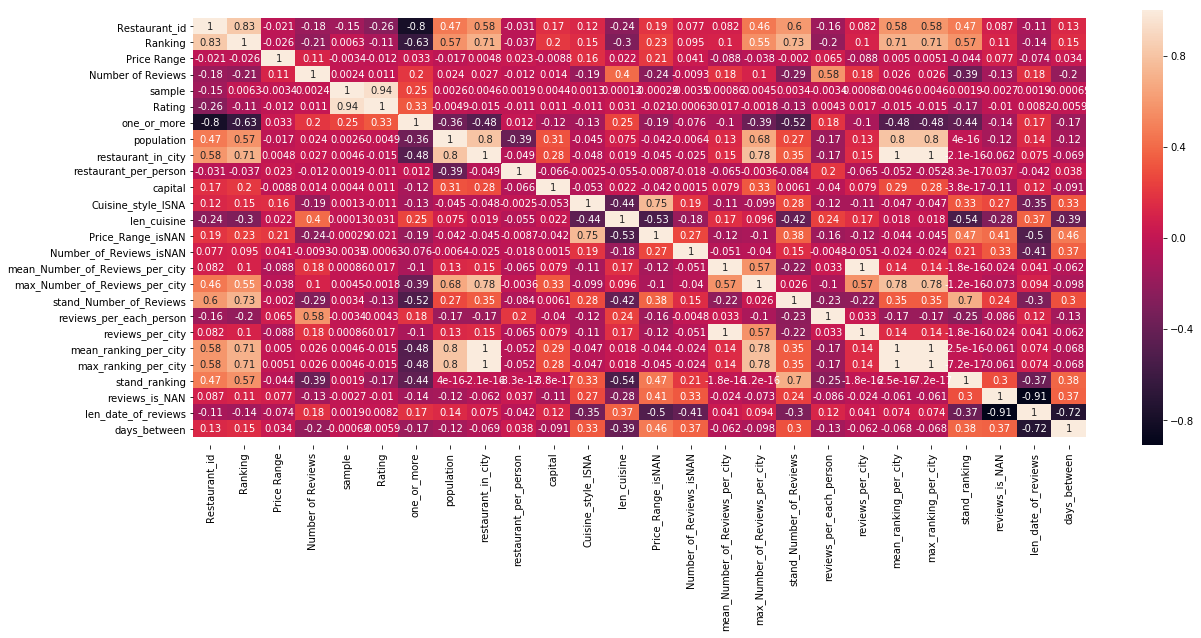

In [46]:
plt.rcParams['figure.figsize'] = (20,8)
ax = sns.heatmap(df_preproc[list_for_corr].corr(), annot=True, fmt='.2g')
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

In [47]:
drop_list = ['mean_ranking_per_city', 'max_ranking_per_city', 'population', 'mean_Number_of_Reviews_per_city']

df_preproc.drop(drop_list, axis=1, inplace=True)

In [48]:
object_columns = df_preproc.select_dtypes(include='object').columns
df_preproc.drop(object_columns, axis = 1, inplace=True)

In [49]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 100 columns):
Restaurant_id                     50000 non-null int64
Ranking                           50000 non-null float64
Price Range                       50000 non-null int64
Number of Reviews                 50000 non-null float64
ID_TA                             50000 non-null int64
sample                            50000 non-null int64
Rating                            50000 non-null float64
one_or_more                       50000 non-null int64
restaurant_in_city                50000 non-null int64
restaurant_per_person             50000 non-null float64
capital                           50000 non-null int64
Amsterdam                         50000 non-null uint8
Athens                            50000 non-null uint8
Barcelona                         50000 non-null uint8
Berlin                            50000 non-null uint8
Bratislava                        50000 non-null uint8
Br

In [50]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

In [51]:
test_data

,Restaurant_id,Ranking,Price Range,Number of Reviews,ID_TA,Rating,one_or_more,restaurant_in_city,restaurant_per_person,capital,...,Price_Range_isNAN,Number_of_Reviews_isNAN,max_Number_of_Reviews_per_city,stand_Number_of_Reviews,reviews_per_each_person,reviews_per_city,stand_ranking,reviews_is_NAN,len_date_of_reviews,days_between
0,0,12963.0,1,4.0,10746918,0.0,16,6108,0.918526,1,...,0,0,7622.0,1.685379,-0.276842,117.040915,0.430748,1,0,1800
2,5,5093.0,0,24.0,8458643,0.0,12,6108,0.918526,1,...,0,0,7622.0,0.652842,-0.253830,117.040915,-0.131957,0,2,5
5,15,12899.0,0,39.0,7605609,0.0,8,6108,0.918526,1,...,0,0,7622.0,1.676982,-0.236571,117.040915,0.426172,0,2,50
12,31,3156.0,1,19.0,11953078,0.0,13,6108,0.918526,1,...,1,0,7622.0,0.398709,-0.259583,117.040915,-0.270453,0,1,3600
14,34,476.0,1,136.0,9597870,0.0,7,6108,0.918526,1,...,0,0,7622.0,0.047095,-0.124961,117.040915,-0.462073,0,2,143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,9726,908.0,1,221.0,2098731,0.0,2,836,-0.106340,1,...,0,0,3491.0,0.215905,0.728453,154.276382,-0.032718,0,2,42
49996,9818,876.0,1,40.0,10713491,0.0,1,836,-0.106340,1,...,0,0,3491.0,0.206738,-0.098658,154.276382,-0.049045,0,2,45
49997,9825,1731.0,1,5.0,10004041,0.0,2,836,-0.106340,1,...,1,0,3491.0,0.451654,-0.258596,154.276382,0.387180,0,2,100
49998,9839,464.0,0,94.0,716025,0.0,2,836,-0.106340,1,...,0,0,3491.0,0.088721,0.148104,154.276382,-0.259249,0,2,37


In [52]:
test_data = test_data.sort_values(by=['Restaurant_id'])

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [53]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [54]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 99), (40000, 99), (40000, 98), (32000, 98), (8000, 98))

# Model 
Сам ML

In [55]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [56]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [57]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)
y_pred = np.round(y_pred*2) / 2

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [58]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1694375


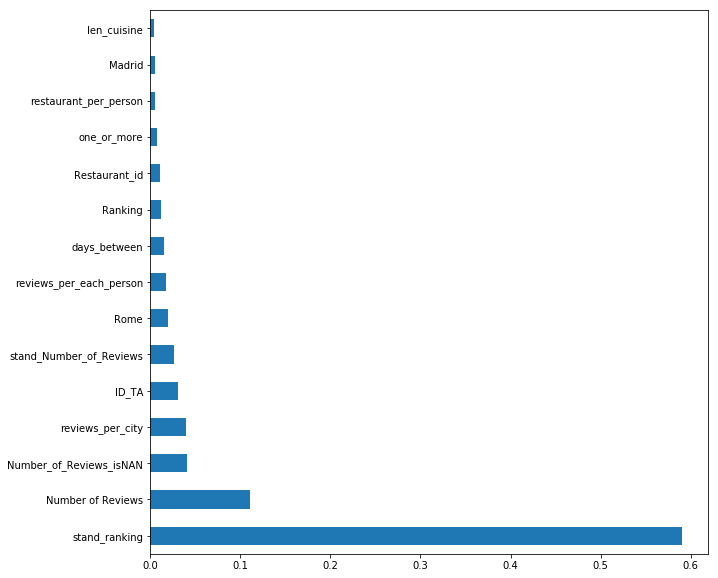

In [59]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [60]:
test_data

,Restaurant_id,Ranking,Price Range,Number of Reviews,ID_TA,Rating,one_or_more,restaurant_in_city,restaurant_per_person,capital,...,Price_Range_isNAN,Number_of_Reviews_isNAN,max_Number_of_Reviews_per_city,stand_Number_of_Reviews,reviews_per_each_person,reviews_per_city,stand_ranking,reviews_is_NAN,len_date_of_reviews,days_between
0,0,12963.0,1,4.0,10746918,0.0,16,6108,0.918526,1,...,0,0,7622.0,1.685379,-0.276842,117.040915,0.430748,1,0,1800
33937,1,106.0,1,97.0,6674944,0.0,10,475,-0.729566,1,...,0,0,1488.0,0.026868,0.100353,66.020134,-0.401605,0,2,37
28433,2,810.0,1,28.0,13129638,0.0,15,745,-0.099059,1,...,0,0,4567.0,0.125310,-0.137009,237.711326,-0.042543,0,2,22
9884,3,1669.0,2,202.0,680417,0.0,9,7193,-0.690755,1,...,0,0,9660.0,0.158492,-0.225529,137.968381,-0.395324,0,2,14
41027,4,37.0,2,162.0,1112354,0.0,14,380,-0.615666,1,...,0,0,2578.0,-0.005670,0.667586,51.616099,-0.478548,0,2,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14858,9995,4367.0,0,28.0,11916827,0.0,3,7193,-0.690755,1,...,0,0,9660.0,0.437788,-0.273694,137.968381,-0.231252,0,2,122
28430,9996,2612.0,1,2.0,12701633,0.0,1,1646,1.263826,1,...,0,0,3404.0,0.729780,-0.271592,127.830078,0.200342,0,1,3600
19768,9997,5562.0,1,2.0,13198194,0.0,1,2694,0.256535,0,...,1,0,6360.0,0.848066,-0.277765,168.298869,0.391390,1,0,1800
19769,9998,4010.0,1,2.0,3862815,0.0,1,2694,0.256535,0,...,1,0,6360.0,0.604041,-0.277765,168.298869,0.144059,1,0,1800


In [61]:
test_data.sample(10)

,Restaurant_id,Ranking,Price Range,Number of Reviews,ID_TA,Rating,one_or_more,restaurant_in_city,restaurant_per_person,capital,...,Price_Range_isNAN,Number_of_Reviews_isNAN,max_Number_of_Reviews_per_city,stand_Number_of_Reviews,reviews_per_each_person,reviews_per_city,stand_ranking,reviews_is_NAN,len_date_of_reviews,days_between
26667,4684,1394.0,1,12.000000,5002440,0.0,2,1126,0.415819,0,...,1,0,1953.0,0.669189,-0.223315,87.073216,0.033795,0,1,3600
40999,8902,2474.0,1,5.000000,10492500,0.0,2,1145,-0.708778,0,...,0,0,4694.0,0.510514,-0.272996,77.649387,0.399458,1,0,1800
42927,4856,421.0,1,25.000000,10745891,0.0,3,222,-0.696234,1,...,0,0,2006.0,0.165874,-0.059153,88.256039,0.398485,0,2,6
38229,431,102.0,2,604.000000,694877,0.0,13,1816,-0.224511,1,...,0,0,4521.0,-0.004950,0.866150,124.377722,-0.473968,0,2,6
13699,7682,11136.0,1,4.000000,4173772,0.0,2,7193,-0.690755,1,...,1,0,9660.0,1.138513,-0.280337,137.968381,0.180388,0,2,209
2382,5028,3328.0,1,106.000000,3706422,0.0,3,6108,0.918526,1,...,0,0,7622.0,0.421275,-0.159480,117.040915,-0.258155,0,2,94
13251,6826,5513.0,1,79.000000,734009,0.0,2,7193,-0.690755,1,...,0,0,9660.0,0.556421,-0.259577,137.968381,-0.161561,0,2,8
25078,9084,124.0,1,244.000000,3966986,0.0,2,1033,-0.286869,1,...,0,0,1461.0,0.033404,0.487454,75.197479,-0.451900,0,2,149
20723,2287,6080.0,1,5.000000,10176590,0.0,9,3813,-0.387183,1,...,1,0,6013.0,0.994527,-0.277588,99.911888,0.192018,0,1,3600
10448,1131,16313.0,0,137.968381,10075998,0.0,14,7193,-0.690755,1,...,0,1,9660.0,1.674434,-0.243253,137.968381,0.495214,0,1,3600


In [62]:
test_data = test_data.sort_values(by=['Restaurant_id'])
test_data = test_data.drop(['Rating'], axis=1)

In [63]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [64]:
predict_submission = model.predict(test_data)
predict_submission = np.round(predict_submission*2) / 2

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [65]:
predict_submission

array([3.5, 4. , 4.5, ..., 3. , 4.5, 4. ])

In [66]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [67]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('new_submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.5
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.0
7,id_7,3.0
8,id_8,4.0
9,id_9,4.5


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
